In [21]:
import nest
import nest.raster_plot
import numpy as np
import matplotlib.pyplot as plt
import time

def run_brunel_network(N_total=12500, epsilon=0.1, J_ex=0.1, g=5.0, eta=2.0, sim_time=1000.0):
    '''
    Simulates a Brunel network of spiking neurons using NEST.
    Parameters:
    - N_total: Total number of neurons in the network.
    - epsilon: Connection probability.
    - J_ex: Excitatory synaptic weight amplitude (mV).
    - g: Relative inhibitory strength (J_in = -g * J_ex).
    - eta: External rate relative to threshold.
    - sim_time: Duration of the simulation in milliseconds.
    '''
    # NEST Initialization
    # -------------------
    nest.ResetKernel()
    nest.total_num_virtual_procs = 5
    nest.set_verbosity("M_WARNING")

    # Parameter Definition
    # -----------------------
    # Network parameters
    NE = int(0.8 * N_total)    # Number of Excitatory neurons
    NI = int(0.2 * N_total)    # Number of Inhibitory neurons
    
    # Connection parameters
    CE = int(epsilon * NE)     # Indegree from Excitatory
    CI = int(epsilon * NI)     # Indegree from Inhibitory

    # Neuron parameters (from Gerstner et al. 2014)
    tauMem = 20.0  # time constant of membrane potential in ms
    CMem = 1.0  # capacitance of membrane in in pF
    theta = 20.0  # membrane threshold potential in mV
    neuron_params = {
        "C_m": CMem,
        "tau_m": tauMem,
        "t_ref": 2.0,
        "E_L": 0.0,
        "V_reset": 10.0,
        "V_th": theta,
    }
        
    # Synaptic weights
    J_in = -g * J_ex           # Inhibitory weight amplitude
    delay = 1.5                # Synaptic delay (ms)

    # External drive parameters
    nu_th = (theta / (J_ex * CE * tauMem)) * 1000.0   # Threshold rate (Hz) - approximated for parameters
    nu_ext = eta * nu_th       # External Poisson rate (Hz)
    p_rate = nu_ext * CE # Poisson generator rate (spikes/s)

    # Simulation parameters
    dt = 0.1                   # Simulation resolution (ms)

    nest.resolution = dt
    nest.print_time = True
    nest.overwrite_files = True

    print(f"Building network with {N_total} neurons...")

    # Create Nodes
    # ---------------
    # Create neurons (iaf_psc_delta is standard for Brunel 2000)
    nodes_ex = nest.Create("iaf_psc_delta", NE, params=neuron_params)
    nodes_in = nest.Create("iaf_psc_delta", NI, params=neuron_params)
    
    # Create external noise (Poisson generator)
    noise = nest.Create("poisson_generator", N_total, params={"rate": p_rate})
    noise.rate = nu_ext * CE  # Rate adjusted for indegree

    # Create spike recorder for excitatory and inhibitory neurons
    espikes = nest.Create("spike_recorder")
    ispikes = nest.Create("spike_recorder")
    espikes.set(label="brunel-py-ex", record_to="ascii")
    ispikes.set(label="brunel-py-in", record_to="ascii")

    # Connect Network
    # ------------------
    # Configure synapse specifications
    syn_ex = {"weight": J_ex, "delay": delay}
    syn_in = {"weight": J_in, "delay": delay}
    
    # Configure connection rule (Fixed Indegree)
    conn_params_ex = {"rule": "fixed_indegree", "indegree": CE}
    conn_params_in = {"rule": "fixed_indegree", "indegree": CI}

    print("Connecting devices...")

    nest.CopyModel("static_synapse", "excitatory", syn_ex)
    nest.CopyModel("static_synapse", "inhibitory", syn_in)
    
    # Connect External Noise -> All Neurons
    nest.Connect(noise, nodes_ex + nodes_in, "one_to_one", syn_spec="excitatory")
    # Connect Excitatory Population -> All Neurons
    nest.Connect(nodes_ex, nodes_ex + nodes_in, conn_params_ex, syn_ex)
    # Connect Inhibitory Population -> All Neurons
    nest.Connect(nodes_in, nodes_ex + nodes_in, conn_params_in, syn_in)

    # Connect Neurons -> Spike Recorder
    # (Recording only first 50 E and 50 I neurons to save memory)
    nest.Connect(nodes_ex[:100], espikes, syn_spec="static_synapse")
    nest.Connect(nodes_in[:100], ispikes, syn_spec="static_synapse")

    # Run Simulation
    # -----------------
    print(f"Simulating for {sim_time} ms...")
    start_time = time.time()
    nest.Simulate(sim_time)
    end_time = time.time()
    
    print(f"Simulation finished in {end_time - start_time:.2f} s")
    nest.raster_plot.from_device(espikes, hist=True)
    plt.show()
    nest.raster_plot.from_device(ispikes, hist=True)
    plt.show()

Building network with 12500 neurons...
Connecting devices...
Simulating for 1000.0 ms...
Simulation finished in 19.91 s


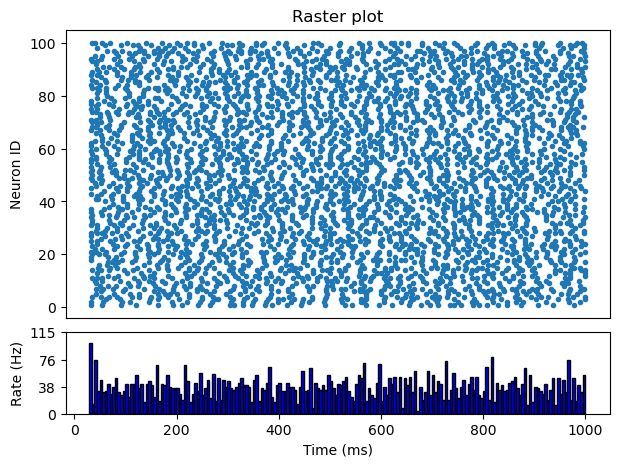

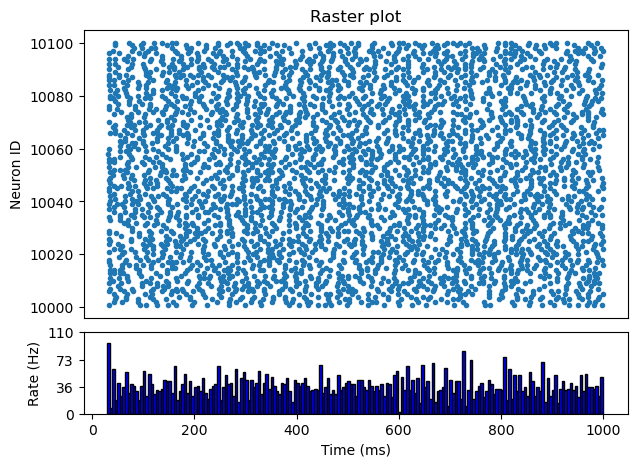

In [22]:
run_brunel_network()